# MAT 186: Fitting an Exponential Function to Biological Data

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import urllib.request


# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In this demo we use exponentials and logarithms to help model real biological data on paramecium populations collected by Georgy Gause in the 1920s. We'll find that logs can be used to transform the data and reduce finding the "best" model parameters to drawing a line of best fit. 

First, we fetch and load the data from a github repo I created. **You can skip this part unless you're a Python prodigy: certainly, it doesn't affect any of the main math ideas!** Running this code box creates a folder called "datasets" in your current directory, and puts a file called "gause_data.csv" into that folder. 

In [4]:
# add the folder "datasets" to our path... more on this below
PATH = os.path.join("datasets") 

# specify the URL where the data can be downloaded
URL = "https://github.com/ageorgemorgan/mathcircles/blob/main/gause_data.csv"

# create a function that creates a folder called 'datasets' in your current directory, downloads
# the data from my git repo, and finally loads the data as a Pandas dataframe. 
def fetch_and_load_gause_data(my_url=URL, my_path=PATH):
    # first, if the 'datasets' folder doesn't exist, make it
    if not os.path.isdir(my_path):
        os.makedirs(my_path)
    # then add the filename of the data file to your path
    csv_path = os.path.join(my_path, "gause_data.csv")
    # download the data from the url specified above and save it to the datasets folder
    # with the specified name
    urllib.request.urlretrieve(my_url, csv_path)
    # finally, use Pandas to read the data... 
    data = pd.read_csv("gause_data.csv")
    # and output the resulting Pandas dataframe
    return data 

#now just call the handy function above and presto, you have 
# an up-to-date version of the data ready to play with! 
data = fetch_and_load_gause_data()

Since the data was loaded as a Pandas dataframe object, it can be tabulated with one line of code: 

In [5]:
display(data)

,Day,Density,Change in Density
0,0,2.0,NaN
1,1,NaN,NaN
2,2,14.0,20.0
3,3,34.0,22.0
4,4,56.0,38.0
5,5,94.0,95.0
6,6,189.0,77.0
7,7,266.0,64.0
8,8,330.0,86.0
9,9,416.0,91.0


Since the measurement on day one was not reported by Gause, we "clean" the data and start from day 2. For this exercise, we'll only look at days 2 to $N$ (inclusive). By default, $N=6$. So, we trim our vector of measurements: 

In [6]:
N = 6 # you can play with this parameter and see how the fit changes as we include more data!

In [7]:
p_meas = data['Density'].to_numpy()
p_meas = p_meas[2:N+1]

We'll also need a vector of measurement times (that is, the values of the manipulated variable). 

In [8]:
t_meas = np.arange(2,N+1)

Now, we plot the chunk of data we're interested in. 

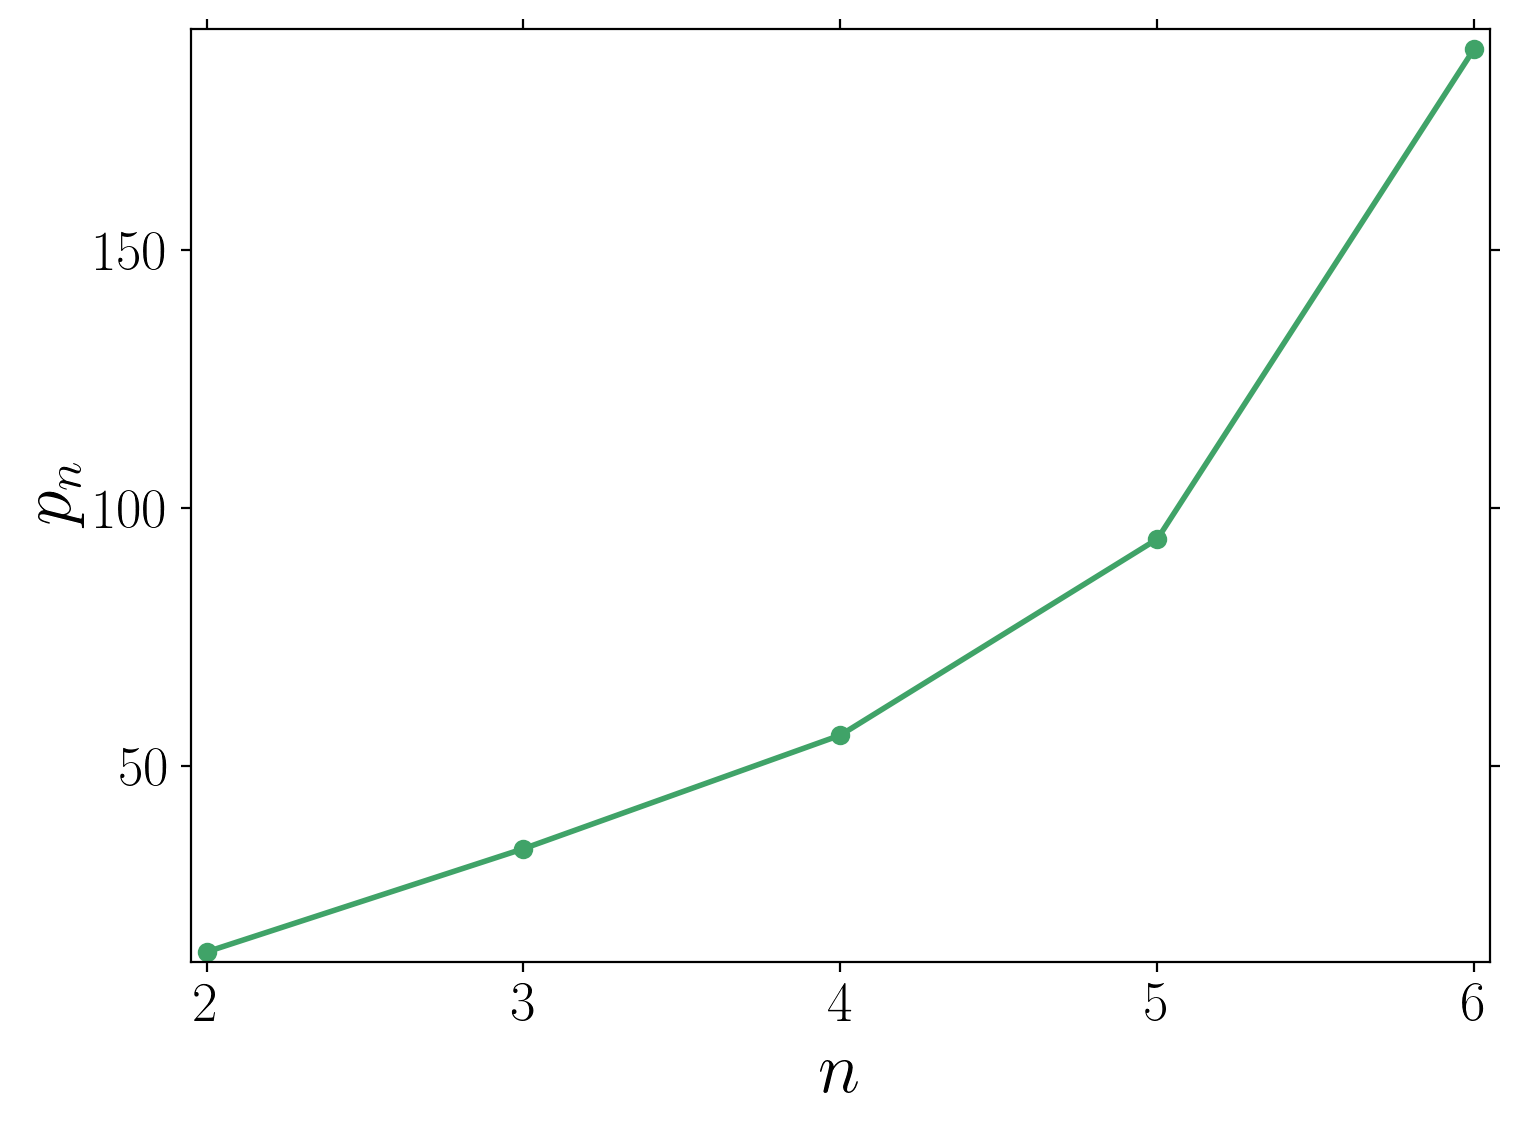

In [18]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(t_meas, p_meas, 'o-', color='xkcd:greenish', linewidth=2)

# the rest of this is just plot labelling, don't worry about it 
plt.xlabel(r"$n$", fontsize=26, color = 'k')
plt.ylabel(r"$p_{n}$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=20, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=20, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=5)

plt.xlim([2-0.05, N+0.05])
plt.ylim([12, p_meas[-1]*1.02])

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
# uncomment if you want to save a pic
figname = 'gause_raw_data_selected_days.jpg'
plt.savefig(figname, dpi=600)

plt.show()

When $N=6$, the growth does appear to be exponential! For larger $N$, however, the story is more complicated. 

With this observation in mind, it's sensible to try and fit the data to a function of the form 
$$
p(t) = p_{*}e^{r(t-2)}, \quad t\geq 2. 
$$
where $p_{*}$, $r$ are fixed parameters. We want to determine $p_{*}, r$ from the data in such a way that 
$$
p(n) \approx p_{n}. 
$$
Actually, $p_{*}$ can be determined immediately: we find that 
$$
p(2) = p_{*}
$$
and we can set $p_{*}=p(2)=p_{2}=14$ (from the tabulated data displayed above). So, it remains to find the "best" growth rate $r$ that fits the data. 

Before explaining how to compute the "best" value of $r$, it's helpful to re-define our time variable to 
$$
\tilde{t} = t-2
$$
so that 
$$
p\left(\tilde{t}\right) = 14e^{r\tilde{t}}, \quad \tilde{t}\geq 0. 
$$
In the code below, we call $\tilde{t}$ by the name $\texttt{t_shifted}$. 

In [10]:
t_shifted = t_meas - 2. 

How can we determined $r$ from the scatterplot of $(n, p_{n})$? Our strategy is to properly transform the data, then draw a **line of best fit**. Simply put, lines of best fit are conceptually very simple, and there is plenty of software for **linear regression**, or automatically determining lines of best fit from data (you may discuss some examples in your linear algebra course). The problem of directly fitting to a *nonlinear* function such as an exponential is more complicated in general (but not impossible). 

Now, how do we transform our nonlinear function of time $p\left(\tilde{t}\right)$ into a linear function of $\tilde{t}$? A trivial algebra exercise shows
$$
\ln\left(\frac{p\left(\tilde{t}\right)}{14}\right) = r\tilde{t}. 
$$
If we then *define* our transformed population density by 
$$
\tilde{p}(t) = \ln\left(\frac{p\left(\tilde{t}\right)}{14}\right),
$$
we find that 
$$
\tilde{p}(t) = r\tilde{t}.
$$
Therefore, using logs allows us to replace a *nonlinear model* with a *linear one*! This greatly simplifies our work. In particular, we have found that **the $r$ value that fits our data best should be the slope of a best-fine line.**

In [12]:
# defining reshaped (for regressor-related reasons) transformed data
tt = np.reshape(t_shifted, (-1,1))
p0 = p_meas[0]
pp = np.log(p_meas/p0).reshape(-1,1) # note: in numpy log = natural logarithm 

Let's construct a scatterplot of the transformed data to see if it actually appears to be roughly linear: 

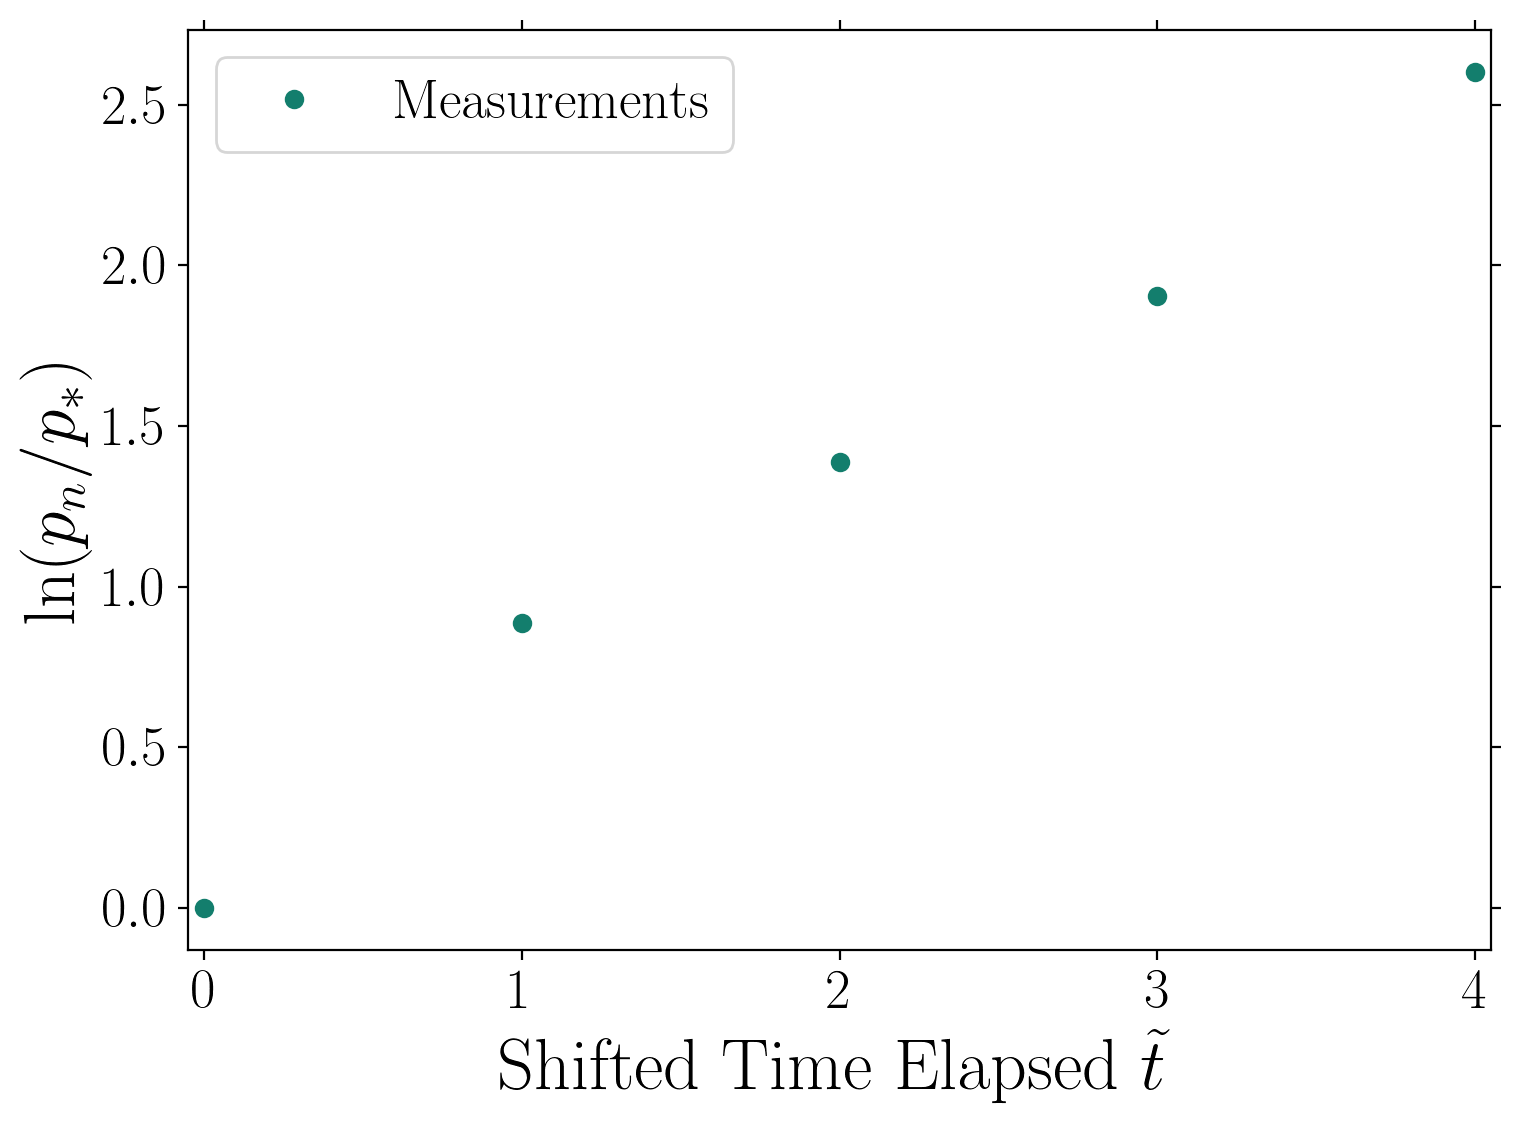

In [13]:
fig, ax = plt.subplots()

plt.plot(tt, pp, 'o', color='xkcd:blue green', label='Measurements')

# the rest of this is just plot labelling, don't worry about it 
plt.xlabel(r"Shifted Time Elapsed $\tilde{t}$", fontsize=26, color = 'k')
plt.ylabel(r"$\ln(p_n/p_{*})$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=20, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=20, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=5)

plt.xlim([-0.05, 4.05])
#plt.ylim([0, 200])

ax.legend(fontsize=20)

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
# uncomment if you want to save a pic
figname = 'semilogy_scatterplot.jpg'
plt.savefig(figname, dpi=600)

plt.show()

So, at least for $N=6$, the data lie (nearly) on a straight line! We can determine this line-of-best-fit using the scikit-learn (sklearn) machine learning library (linear regression is the simplest form of machine learning!). 

In [14]:
from sklearn import linear_model

regressor = linear_model.LinearRegression()
regressor.fit(tt, pp)

r_best = regressor.coef_[0]

print('Regressor Estimate = ', r_best)

Regressor Estimate =  [0.62223136]


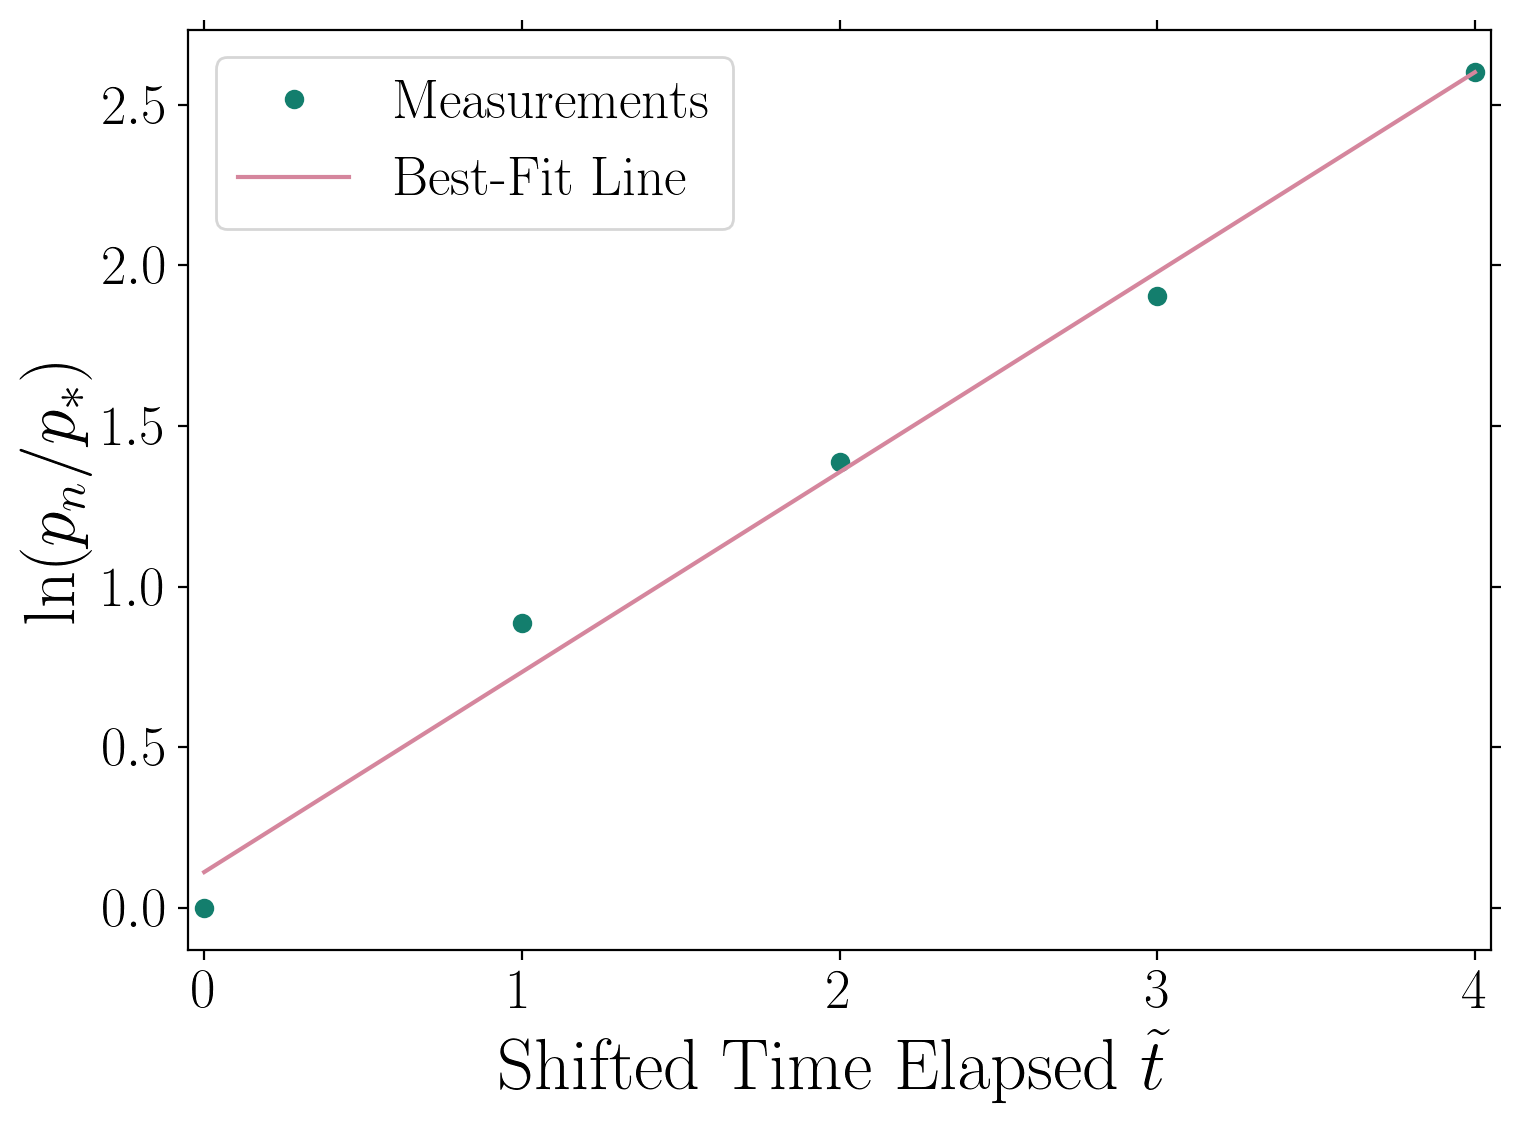

In [19]:
fig, ax = plt.subplots()

plt.plot(tt, pp, 'o', color='xkcd:blue green', label='Measurements')
plt.plot(tt, regressor.predict(tt), 'xkcd:dull pink', label='Best-Fit Line')

# the rest of this is just plot labelling, don't worry about it 
plt.xlabel(r"Shifted Time Elapsed $\tilde{t}$", fontsize=26, color = 'k')
plt.ylabel(r"$\ln(p_n/p_{*})$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=20, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=20, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=5)

plt.xlim([-0.05, 4.05])
#plt.ylim([0, 200])

ax.legend(fontsize=20)

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
# uncomment if you want to save a pic
figname = 'gause_semilogy_fit.jpg'
plt.savefig(figname, dpi=600)

plt.show()

Having used regression software to find the best $r$ for our data, we can transform back to the original variables $t, p(t)$ and see how well our fit does: 

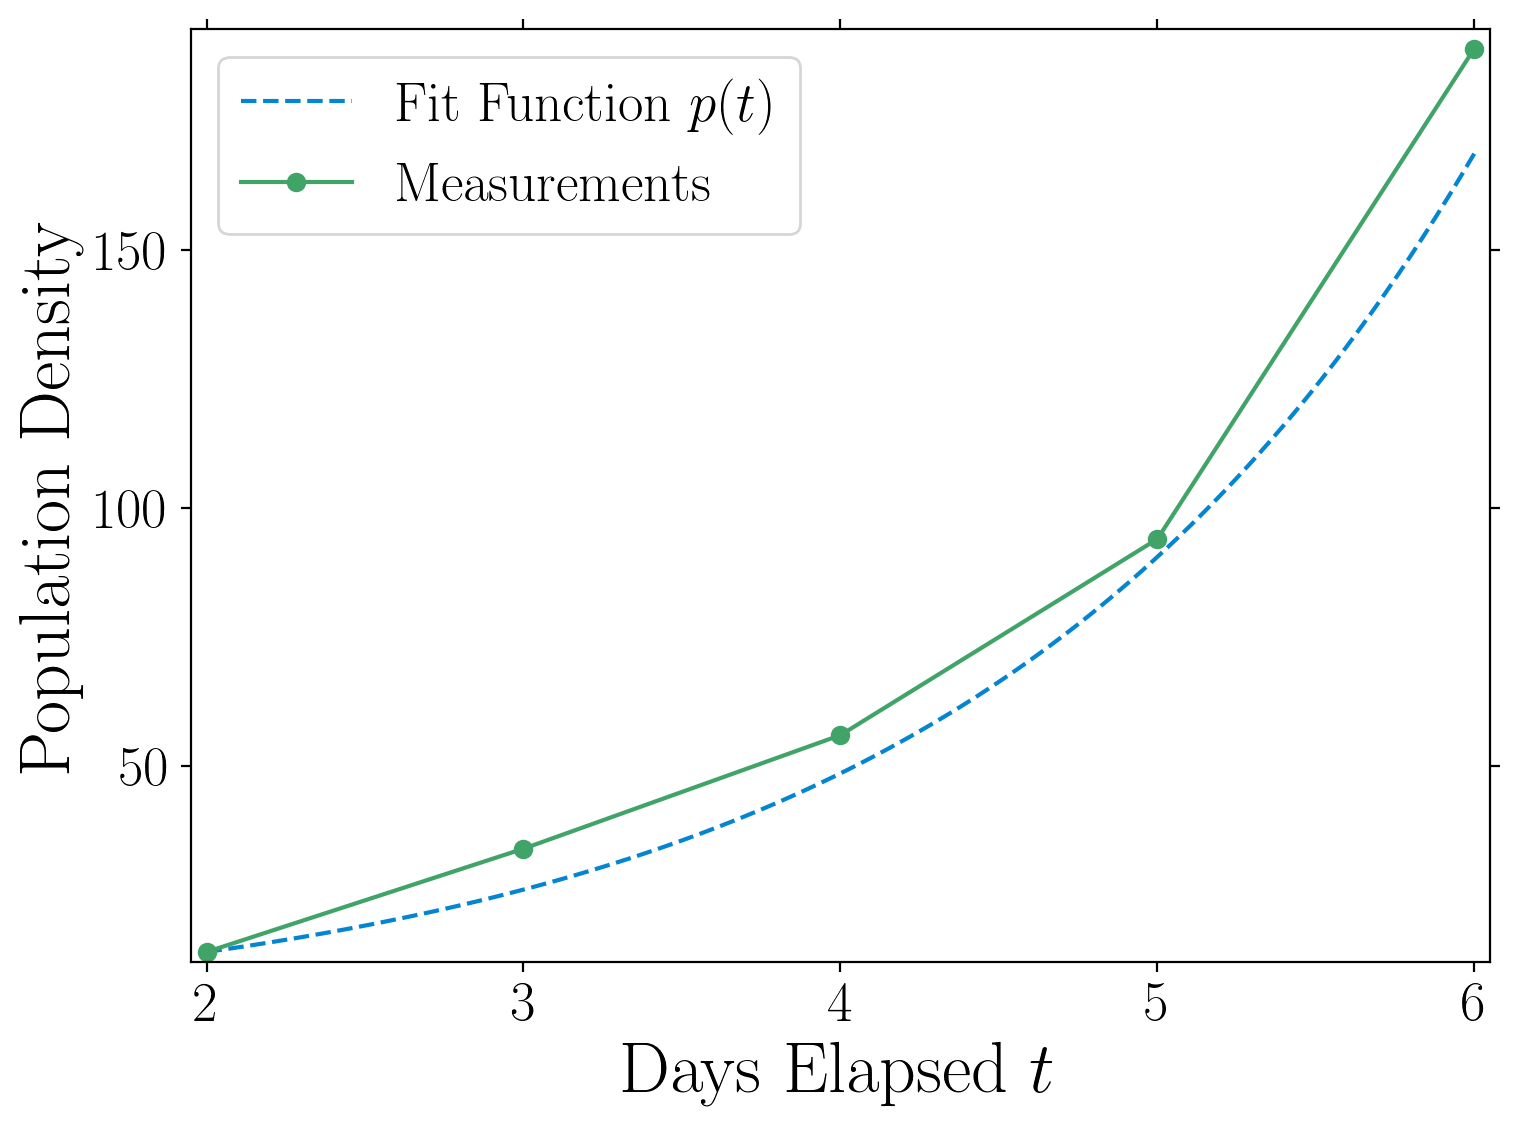

In [17]:
fig, ax = plt.subplots()

t_plt = np.linspace(2,N,100)
plt.plot(t_plt, p0*np.exp(r_best*(t_plt-2.)), color='xkcd:cerulean', linestyle='--', label='Fit Function $p(t)$')
plt.plot(tt+2, p_meas, 'o-', color='xkcd:greenish', label='Measurements')

# the rest of this is just plot labelling, don't worry about it 
plt.xlabel(r"Days Elapsed $t$", fontsize=26, color = 'k')
plt.ylabel(r"Population Density", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=20, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=20, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=5)

plt.xlim([2-0.05, N+.05])
plt.ylim([12, 1.02*p_meas[-1]])

ax.legend(fontsize=20)

plt.tight_layout()

fig.set_size_inches(8, 6)  
      
# uncomment if you want to save a pic
figname = 'gause_prediction_vs_meas.jpg'
plt.savefig(figname, dpi=600)

plt.show()

At least for $N=6$, the fit seems pretty good! 

Does increasing $N$ affect the quality of the fit? Run the code with a larger $N$ and see what happens! 